In [1]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# For iSOM Data Generation
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score, accuracy_score

# --- Installation Note ---
# !pip install tabpfn minisom sklearn pandas seaborn matplotlib tqdm

print("Setup Complete!")

Setup Complete!


In [2]:
# ===================================================================
# Cell 2: BALANCED Interpretable SOM (iSOM) Synthetic Data Generator
# ===================================================================
# This is a new, more advanced version of the generator that creates
# a balanced number of synthetic samples for each class.

def generate_isom_data_balanced(df_real, target_column, num_synthetic_total):
    if num_synthetic_total <= 0:
        return pd.DataFrame(columns=df_real.columns)

    print(f"Generating {num_synthetic_total} BALANCED synthetic samples from a base of {len(df_real)} real samples...")
    
    unique_classes = df_real[target_column].unique()
    num_classes = len(unique_classes)
    n_samples_per_class = num_synthetic_total // num_classes

    all_synthetic_dfs = []

    for class_label in unique_classes:
        df_class = df_real[df_real[target_column] == class_label]
        
        if len(df_class) < 2: # Need at least 2 samples to learn from
            print(f"Warning: Skipping class {class_label} for generation, not enough samples.")
            continue
            
        X_class = df_class.drop(columns=[target_column]).values
        
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X_class)

        map_size = int(np.sqrt(5 * np.sqrt(X_scaled.shape[0])))
        som_grid_size = (max(2, map_size), max(2, map_size))
        
        som = MiniSom(som_grid_size[0], som_grid_size[1], X_scaled.shape[1],
                      sigma=1.0, learning_rate=0.5, random_seed=42)
        som.train_random(X_scaled, 500)

        weights = som.get_weights()
        synthetic_samples = []
        rng = np.random.default_rng(42)

        for _ in range(n_samples_per_class):
            idx1 = rng.integers(0, som_grid_size[0] * som_grid_size[1])
            idx2 = rng.integers(0, som_grid_size[0] * som_grid_size[1])
            
            node1_weights = weights.reshape(-1, X_scaled.shape[1])[idx1]
            node2_weights = weights.reshape(-1, X_scaled.shape[1])[idx2]

            alpha = rng.random()
            new_sample_scaled = alpha * node1_weights + (1 - alpha) * node2_weights
            synthetic_samples.append(new_sample_scaled)

        df_synth_class_features = pd.DataFrame(scaler.inverse_transform(synthetic_samples), columns=df_class.drop(columns=[target_column]).columns)
        df_synth_class_features[target_column] = class_label
        all_synthetic_dfs.append(df_synth_class_features)

    final_synthetic_df = pd.concat(all_synthetic_dfs, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    return final_synthetic_df

In [3]:
# ===================================================================
# Cell 3: Helper Functions (Data Loading)
# ===================================================================

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path, dataset_name):
    with open(os.path.join(base_path, dataset_name, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, dataset_name, f"{dataset_name}.{meta['format']}"))
    
    # Use the dedicated test set if it exists
    test_path = os.path.join(base_path, dataset_name, f"{dataset_name}_test.{meta['format']}")
    if os.path.exists(test_path):
        print(f"Found dedicated test set for {dataset_name}.")
        test_data = read_data(test_path)
    else:
        print(f"No dedicated test set for {dataset_name}. Splitting will be handled by index file.")
        test_data = None # Will be split from train_data later
        
    return train_data, test_data, meta

def get_indices_for_repeat(base_path, dataset_name, repeat_idx):
    train_idx_file = os.path.join(base_path, dataset_name, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)
    col_name = train_idx_splits.columns[repeat_idx]
    return train_idx_splits[col_name].values

In [4]:
# ===================================================================
# Cell 4: Main Configuration
# ===================================================================
BASE_DATA_PATH = "data"
DATASETS_TO_RUN = [
    "airfoil_cl", "airfoil_cl_m", "framed_safety", "framed_validity", 
    "solar_hex", "truss_6d", "welded_beam", "welded_beam_balanced"
]
REPEATS = 3

# --- Experiment Parameters ---
STARTING_REAL_FRACTIONS = [0.1, 0.3, 0.5]
POOL_TRAINING_FRACTIONS = [0.2, 0.4, 0.6, 0.8, 1.0]
BASELINE_REAL_FRACTIONS = np.arange(0.1, 1.1, 0.1).round(1)

In [6]:
# ===================================================================
# Cell 5: Main Experiment Loop
# ===================================================================
all_results = []
classifier = TabPFNClassifier(device="cuda")

for dataset_name in tqdm(DATASETS_TO_RUN, desc="Overall Dataset Progress"):
    print(f"\n===== Running Dataset: {dataset_name} =====")
    
    full_train_data, test_data_from_file, meta = load_data(BASE_DATA_PATH, dataset_name)
    y_column = meta["label"]

    if pd.api.types.is_float_dtype(full_train_data[y_column]):
        threshold = full_train_data[y_column].median()
        full_train_data[y_column] = (full_train_data[y_column] <= threshold).astype(int)
        if test_data_from_file is not None:
            test_data_from_file[y_column] = (test_data_from_file[y_column] <= threshold).astype(int)

    X_columns = full_train_data.columns.drop(y_column)
    full_train_size = len(full_train_data)

    for i in range(REPEATS):
        shuffled_indices = get_indices_for_repeat(BASE_DATA_PATH, dataset_name, i)
        
        # Determine the test set for this repeat
        if test_data_from_file is not None:
            X_test, y_test = test_data_from_file[X_columns], test_data_from_file[y_column]
        else: # Split from the main data if no dedicated test file
            train_idx_for_split, test_idx_for_split = np.split(shuffled_indices, [int(0.8 * len(shuffled_indices))])
            X_test, y_test = full_train_data.loc[test_idx_for_split, X_columns], full_train_data.loc[test_idx_for_split, y_column]

        # --- Baseline Experiment ---
        for real_fraction in BASELINE_REAL_FRACTIONS:
            n_real = int(real_fraction * full_train_size)
            train_indices = shuffled_indices[:n_real]
            
            X_train, y_train = full_train_data.loc[train_indices, X_columns], full_train_data.loc[train_indices, y_column].astype(int)

            # --- FIX: Subsample if training data exceeds the limit ---
            TABPFN_TRAINING_LIMIT = 10000
            if len(X_train) > TABPFN_TRAINING_LIMIT:
                print(f"Warning: Baseline training set ({len(X_train)}) > {TABPFN_TRAINING_LIMIT}. Subsampling...")
                # Join X and y to sample them together, then split back
                training_subset = X_train.join(y_train).sample(n=TABPFN_TRAINING_LIMIT, random_state=i)
                X_train = training_subset[X_columns]
                y_train = training_subset[y_column]

            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            all_results.append({"dataset": dataset_name, "experiment": "Baseline (Real Only)", "total_fraction": real_fraction, "f1_score": score})

        # --- Augmentation Experiment ---
        for start_fraction in STARTING_REAL_FRACTIONS:
            n_real = int(start_fraction * full_train_size)
            real_indices = shuffled_indices[:n_real]
            real_subset = full_train_data.loc[real_indices]
            
            n_synthetic = full_train_size - n_real
            synthetic_data = generate_isom_data_balanced(real_subset, y_column, n_synthetic)
            data_pool = pd.concat([real_subset, synthetic_data]).sample(frac=1, random_state=i) # Shuffle the pool
            
            for pool_fraction in POOL_TRAINING_FRACTIONS:
                n_pool_samples = int(pool_fraction * len(data_pool))
                training_subset_from_pool = data_pool.head(n_pool_samples)
                X_train, y_train = training_subset_from_pool[X_columns], training_subset_from_pool[y_column].astype(int)
                
                # --- FIX: Subsample if training data exceeds the limit ---
                TABPFN_TRAINING_LIMIT = 10000
                if len(X_train) > TABPFN_TRAINING_LIMIT:
                    print(f"Warning: Augmented training set ({len(X_train)}) > {TABPFN_TRAINING_LIMIT}. Subsampling...")
                    # Join X and y to sample them together, then split back
                    training_subset = X_train.join(y_train).sample(n=TABPFN_TRAINING_LIMIT, random_state=i)
                    X_train = training_subset[X_columns]
                    y_train = training_subset[y_column]

                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_test)
                score = f1_score(y_test.astype(int), y_pred, average="macro")
                all_results.append({"dataset": dataset_name, "experiment": f"Start {int(start_fraction*100)}% Real (Balanced)", "total_fraction": pool_fraction, "f1_score": score})

results_df = pd.DataFrame(all_results)
print("\n\n===== ALL EXPERIMENTS COMPLETE! =====")

Overall Dataset Progress:   0%|          | 0/8 [00:00<?, ?it/s]


===== Running Dataset: airfoil_cl =====
No dedicated test set for airfoil_cl. Splitting will be handled by index file.
Generating 998 BALANCED synthetic samples from a base of 110 real samples...
Generating 776 BALANCED synthetic samples from a base of 332 real samples...
Generating 554 BALANCED synthetic samples from a base of 554 real samples...
Generating 998 BALANCED synthetic samples from a base of 110 real samples...
Generating 776 BALANCED synthetic samples from a base of 332 real samples...
Generating 554 BALANCED synthetic samples from a base of 554 real samples...
Generating 998 BALANCED synthetic samples from a base of 110 real samples...
Generating 776 BALANCED synthetic samples from a base of 332 real samples...
Generating 554 BALANCED synthetic samples from a base of 554 real samples...

===== Running Dataset: airfoil_cl_m =====
No dedicated test set for airfoil_cl_m. Splitting will be handled by index file.
Generating 998 BALANCED synthetic samples from a base of 110 re

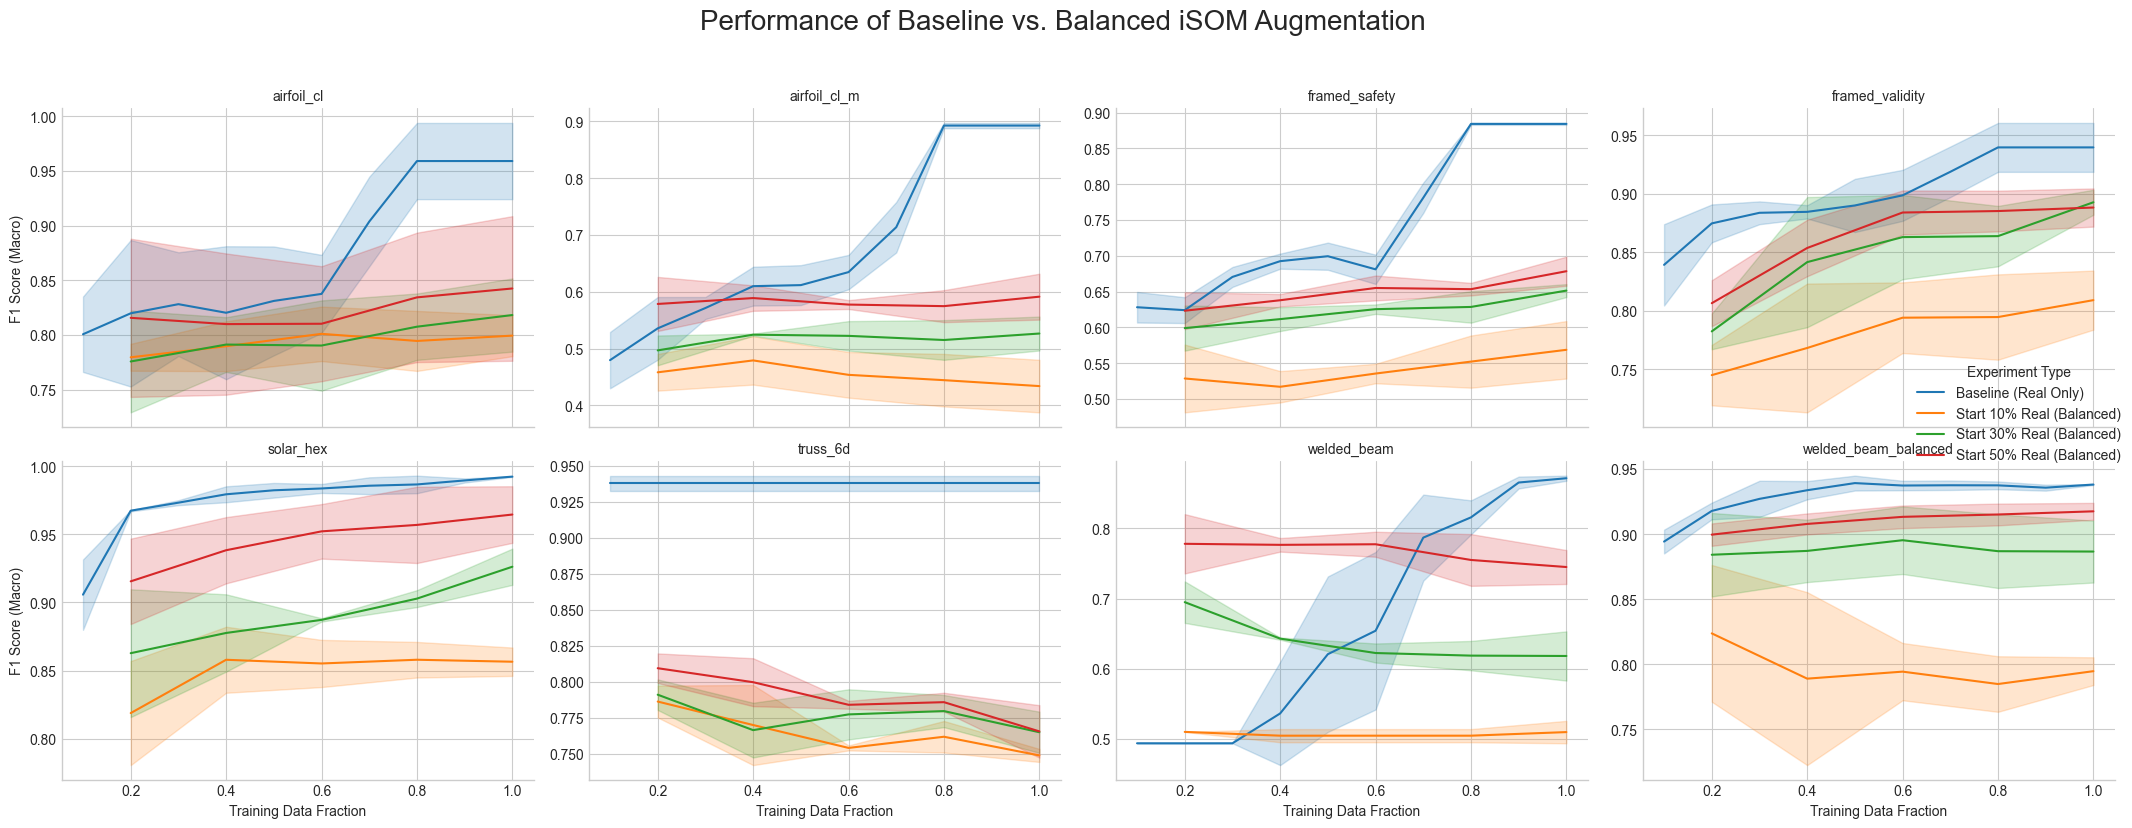

In [9]:
# ===================================================================
# Cell 6: Visualize All Results (Corrected)
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')

experiment_order = ["Baseline (Real Only)"] + [f"Start {int(f*100)}% Real (Balanced)" for f in STARTING_REAL_FRACTIONS]

# --- FIX ---
# We define BOTH hue and style in the FacetGrid constructor.
# This lets the grid manage all the visual mappings and legend creation.
g = sns.FacetGrid(
    results_df, 
    col="dataset", 
    col_wrap=4, 
    hue="experiment",
    # style="experiment",  # Define style here
    hue_order=experiment_order,
    # style_order=experiment_order, # Match the style order
    col_order=DATASETS_TO_RUN,
    height=4, 
    aspect=1.2, 
    sharey=False,
    # legend_out=True # Ensures legend is placed neatly
)

# --- FIX ---
# The map_dataframe call is now very simple. We just tell it what to plot,
# and FacetGrid handles the rest based on the 'hue' and 'style' mappings.
g.map_dataframe(
    sns.lineplot,
    x="total_fraction",
    y="f1_score",
    markers=True,
    errorbar="sd"
).set_titles("{col_name}")


g.set_axis_labels("Training Data Fraction", "F1 Score (Macro)")
g.fig.suptitle("Performance of Baseline vs. Balanced iSOM Augmentation", y=1.03, fontsize=20)
g.add_legend(title="Experiment Type") # Add a title to the legend

# Adjust the layout to make space for the legend
g.fig.tight_layout()

plt.show()